In [ ]:
library(midasr)
library(tidyverse)
library(imputeTS)
library(dplyr)
library(glmnet)
library(dynlm)

Data setup and lag structure

In [9]:
gen_lagged_data <- function(metadata, data, last_date, lag) {
  # Filter data up to the last date
  lagged_data <- data %>%
    dplyr::filter(date <= last_date)
  
  # Store the date column separately
  date_col <- lagged_data$date
  
  # Debug: Print column names to check for discrepancies
  # print("Columns in lagged_data:")
  # print(colnames(lagged_data))
  
  # print("Series in metadata:")
  # print(metadata$series)
  
  # Loop through each series in the filtered metadata
  for (series_name in metadata$series) {
    # Check if the series exists in the data
    if (!series_name %in% colnames(lagged_data)) {
      warning(paste("Series", series_name, "from metadata not found in data"))
      next
    }
    
    pub_lag <- metadata %>%
      dplyr::filter(series == series_name) %>%
      select(months_lag) %>%
      pull()

    # Calculate the condition for applying NA
    condition <- (nrow(lagged_data) - pub_lag - lag)
    
    # Debugging information
    # print(paste("Series:", series_name, "Pub Lag:", pub_lag, "Lag:", lag, "Condition:", condition))
    
    # Apply NA if the condition is valid
    if (!is.na(condition) && condition > 0 && condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), series_name] <- NA
    } else {
      warning(paste("Invalid condition for series:", series_name))
    }
  }
  
  # Reattach the date column
  lagged_data$date <- date_col
  
  # Filter out rows where the date is NA
  lagged_data <- lagged_data %>%
    dplyr::filter(!is.na(date))
  
  return(lagged_data)
}

Variable selection

In [1]:
# Load required libraries
library(readr)
library(dplyr)
library(caret)
library(glmnet)
library(Metrics)

# Set up the directory
current_dir <- getwd()
print(current_dir)
project_dir <- file.path(current_dir, "..")
print(project_dir)
setwd(project_dir)

# Load the data
data_path <- file.path("data", "data_files", "processed_data", "em_imputed_stationary.csv")
if (file.exists(data_path)) {
  data <- read_csv(data_path, show_col_types = FALSE)
} else {
  stop("Data file not found. Please check the file path.")
}

# Return to the original directory
setwd(current_dir)

# Convert 'date' column to Date type and set as index if needed (not commonly done in R)
data <- data %>% arrange(date)

# Fit features and target
target_variable <- "China: GDP: Current Prices:PoP GROWTHRATE"
X <- data %>% select(-all_of(target_variable))
y <- data[[target_variable]]

# Set a seed for reproducibility
set.seed(42)

# Split the data into training and testing sets
trainIndex <- createDataPartition(y, p = 0.8, list = FALSE)
X_train <- X[trainIndex, ]
X_test <- X[-trainIndex, ]
y_train <- y[trainIndex]
y_test <- y[-trainIndex]

# Scale the features
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train_scaled <- predict(scaler, X_train)
X_test_scaled <- predict(scaler, X_test)

# Perform cross-validation to find the optimal lambda
cv_model <- cv.glmnet(as.matrix(X_train_scaled), y_train, alpha = 1)

# Get the best lambda value
best_lambda <- cv_model$lambda.min

# Train the Lasso model with the best lambda
lasso_model <- glmnet(as.matrix(X_train_scaled), y_train, alpha = 1, lambda = best_lambda)

# Make predictions
y_pred <- predict(lasso_model, s = best_lambda, newx = as.matrix(X_test_scaled))

# Evaluate the model
mse <- mean((y_test - y_pred)^2)
r2 <- 1 - sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2)

cat("Mean squared error:", round(mse, 4), "\n")
cat("R-squared score:", round(r2, 4), "\n")

# Get the coefficients
coef <- coef(lasso_model, s = best_lambda)

# Identify the selected features (non-zero coefficients)
selected_features <- which(coef != 0)[-1]  # Ignore the intercept
selected_feature_names <- colnames(X)[selected_features]

# Display the selected features
cat("Number of features selected by Lasso:", length(selected_features), "\n")
cat("Selected features:", selected_feature_names, "\n")
cat("Coefficients of selected features:", coef[selected_features], "\n")

# Optionally, create a data frame of selected features and their coefficients
selected_features_df <- data.frame(
  'Selected Features' = selected_feature_names,
  'Coefficients' = coef[selected_features]
)
print(selected_features_df)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall




[1] "/Users/leyixu/Desktop/Nowcast/deseasoned"
[1] "/Users/leyixu/Desktop/Nowcast/deseasoned/.."


Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by co

Mean squared error: 33.8058 
R-squared score: 0.4002 
Number of features selected by Lasso: 23 
Selected features: Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE China: Value of Imports and Exports:PoP GROWTHRATE China: Trade Balance:Combine With Forecast:PoP GROWTHRATE ChinaBond: Government Bond YTM: 10Y:PoP chg Percent Change: SSE Composite Index Percent Change: CSI 300 Index USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE China: Financial Institutions: New RMB Loans:PoP GROWTHRATE China: M1:PoP GROWTHRATE China: Credit Lending Weighted Interest Rate of Depository Institutions: 3M:PoP chg China: Steel Industry PMI:PoP chg China Forestry Purchasing Managers' Index:PoP chg China: CPI: Fixed-base Ind

In [2]:
library(lubridate)
library(dplyr)
library(tidyr)
library(readr)

# Set up the directory
setwd(project_dir)

# Load the data
data_path <- file.path("data", "data_files", "processed_data", "deseasonalized_data.csv")
data <- read_csv(data_path)
metadata_path <- file.path("data", "data_files", "processed_data", "meta_monthly_blocks_2.csv")
metadata <- read_csv(metadata_path)

# Return to the original directory
setwd(current_dir)

target_variable <- "China: GDP: Current Prices:PoP GROWTHRATE"

# Function to standardize a single column
z_score <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}

# Applying standardization to the entire dataframe
normalized <- data
normalized[ , !(names(normalized) %in% "date")] <- lapply(normalized[ , !(names(normalized) %in% "date")], z_score)
data <- normalized

# Create a data frame with the selected features
selected_data <- data %>%
  select(all_of(selected_feature_names))

# Add the target variable to the selected data
selected_data[[target_variable]] <- data[[target_variable]]
selected_data$date <- data$date
data <- selected_data
 data$date <- as.Date(data$date)

# which lags to assess
lags <- 0:3

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- as.Date("1992-06-30")
test_start_date <- as.Date("2018-06-30")
test_end_date <- as.Date("2023-12-31")

# will have a rolling test period
# This mimics the real-world nowcasting scenario
# Generate the sequence of quarterly end dates
# Define a function to get the last day of the quarter
last_day_of_quarter <- function(date) {
  quarter_end_month <- c("03-31", "06-30", "09-30", "12-31")
  year <- year(date)
  quarter <- ceiling(month(date) / 3)
  as.Date(paste0(year, "-", quarter_end_month[quarter]))
}

# Generate the sequence of dates
test_dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by = "quarter")

# Apply the function to align to the last day of each quarter
test_dates <- sapply(test_dates, last_day_of_quarter)

# Convert the result to Date type
test_dates <- as.Date(test_dates)

print(test_dates)

# test dataset
test <- dplyr::filter(data, date >= test_start_date, date <= test_end_date) %>%
    as.data.frame()
head(test)
tail(test)

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


Rows: 388 Columns: 85
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl  (84): China: Financial Institutions: Total Deposits Balance: RMB:PoP GR...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 84 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): series, freq
dbl (6): months_lag, block_g1, block_g2, block_g3, block_g4, block_g5

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


 [1] "2018-06-30" "2018-09-30" "2018-12-31" "2019-03-31" "2019-06-30"
 [6] "2019-09-30" "2019-12-31" "2020-03-31" "2020-06-30" "2020-09-30"
[11] "2020-12-31" "2021-03-31" "2021-06-30" "2021-09-30" "2021-12-31"
[16] "2022-03-31" "2022-06-30" "2022-09-30" "2022-12-31" "2023-03-31"
[21] "2023-06-30" "2023-09-30" "2023-12-31"


,Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE,China: Value of Imports and Exports:PoP GROWTHRATE,China: Trade Balance:Combine With Forecast:PoP GROWTHRATE,ChinaBond: Government Bond YTM: 10Y:PoP chg,Percent Change: SSE Composite Index,Percent Change: CSI 300 Index,USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE,...,China: CPI: Fixed-base Index:PoP GROWTHRATE,China: Basket Crude Oil Price Change Rate,China: Consumer Confidence Index:PoP chg,China: Consumer Expectation Index:PoP chg,China: PPI: Means of Production: MoM,Nominal Effective Exchange Rate Index: CNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Industrial Capacity Utilization:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE,date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
1,0.3551479,-0.1274552,0.12365399,-0.09175627,-0.55945729,0.7153377,0.004508102,0.09168171,-0.2007128,-0.182654232,...,0.003166819,-0.058295523,-1.9622634,-1.67779401,1.0170623,-0.45710786,0.1527792,-0.01893564,-0.6849544,2018-06-30
2,2.7004029,0.3224431,0.35876711,0.33614615,-0.03897030,-0.6839909,-0.721647326,0.25578963,0.1119115,0.937512515,...,-0.038429930,-0.117882893,0.6338473,0.43889739,0.4227271,-2.76318346,-0.5223659,NA,NA,2018-07-31
3,-0.8072973,-0.1321368,0.35501219,-0.05227687,0.06564584,-0.2299918,-0.173981737,-0.29219784,-0.3387401,-0.151164801,...,0.280078388,2.211084639,-0.4572310,-0.19742256,1.0072866,-1.20989699,-1.3610273,NA,NA,2018-08-31
4,-1.7312266,-0.9990983,-0.04370212,-0.15987091,-0.00754813,0.3554407,0.339576747,0.05929975,-0.1010326,0.005903373,...,0.281286926,0.009644084,-0.2672091,-0.26301020,1.1820208,-0.09060434,0.3785527,-0.16300588,-0.6119740,2018-09-30
5,0.0479874,1.5415484,1.55524690,-0.18992617,-0.05233378,-0.3629346,0.194536275,0.91483823,1.2874459,1.134447749,...,-0.156523700,-4.231012566,0.1078822,0.02541408,0.9574352,-0.43174951,1.1338221,NA,NA,2018-10-31
6,-0.1628331,-0.9227252,-0.80220116,-0.23940088,-0.34357166,0.6826526,-0.239204635,0.25007305,1.0201555,0.957586203,...,0.215407797,-2.546208414,1.3925808,1.16683106,-0.6492722,-0.32654447,2.6355332,NA,NA,2018-11-30


,Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE,China: Value of Imports and Exports:PoP GROWTHRATE,China: Trade Balance:Combine With Forecast:PoP GROWTHRATE,ChinaBond: Government Bond YTM: 10Y:PoP chg,Percent Change: SSE Composite Index,Percent Change: CSI 300 Index,USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE,...,China: CPI: Fixed-base Index:PoP GROWTHRATE,China: Basket Crude Oil Price Change Rate,China: Consumer Confidence Index:PoP chg,China: Consumer Expectation Index:PoP chg,China: PPI: Means of Production: MoM,Nominal Effective Exchange Rate Index: CNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Industrial Capacity Utilization:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE,date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
62,-0.9921327,-1.6140364,-1.3639569,-1.2415571,-0.63187762,0.1297641,-0.29328221,0.39407193,0.5642927,0.24266170,...,-0.09849378,2.5846974,-0.007638887,-0.22232602,-0.58305570,-0.71472640,0.3451946,NA,NA,2023-07-31
63,-0.8072973,1.2507490,0.6337273,0.5855672,0.28540910,-0.4176778,-0.12922440,-0.35564290,-0.4515097,-0.28149653,...,0.03456353,-0.5844743,0.055957916,0.08098730,0.60497343,0.51613679,-2.7988957,NA,NA,2023-08-31
64,-0.8080927,-0.5326884,0.6071760,0.9187771,0.02084059,0.3103765,0.39227931,0.07315999,-0.0846844,-0.01067405,...,-0.02568731,-0.0531415,0.074916894,0.18940582,0.77970767,0.32057450,0.3300176,0.3151412,-0.8952757,2023-09-30
65,-1.7982804,0.6590822,1.2068570,2.1872992,0.03608120,-0.9496518,-0.03462129,-0.05901600,-0.3459300,-0.37600537,...,-0.34405441,-0.8961773,0.150647903,-0.14859208,-0.04834764,0.71624867,0.4313693,NA,NA,2023-10-31
66,-0.1628331,-0.7819111,-1.1330686,-1.0305388,-0.12537538,0.6420677,-0.41107281,-0.11643256,0.1722388,-0.13237936,...,0.14284534,0.8134212,-0.275283337,-0.05121207,-0.64927219,-0.60173312,0.9906609,NA,NA,2023-11-30
67,0.1817959,-0.9655786,-0.2734001,-0.4898140,-0.64681381,0.4138193,0.31200173,-0.21432804,-0.3015716,0.08070666,...,0.43221660,0.3225439,0.103596469,-0.15375338,-0.54725496,-0.04496989,0.5665563,0.4820953,-0.9872301,2023-12-31


Model training

In [5]:
# dataframe for predictions
pred_dict <- data.frame(date = test_dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}


In [6]:
# Filter metadata to keep only the series that are present in the data
metadata <- metadata %>%
  dplyr::filter(series %in% colnames(data))

In [10]:
#mean imputation
library(dplyr)
library(lubridate)
library(tidyr)
library(midasr)
library(imputeTS)

# For loop for each test date
i <- 1
for (i in seq_along(test_dates)) {
  test_date <- test_dates[i]
  test_date
  
  # Train data up to 3 months before test date
  train <- data %>%
    filter(date >= train_start_date & date <= ceiling_date(test_date, "month") %m-% days(1)) 
  train <- train[-1, ]
  head(train)
  tail(train)
    
  # Estimating MIDAS models
  y <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), target_variable]

  y <- y[[1]] # vector

  models <- list()

  # Train separate MIDAS models for each explanatory variable
  for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable && col != "date") {
      if (col %in% c("China: Industrial Capacity Utilization:PoP chg")) { # quarterly variables
        x <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), col]
        x <- x[[1]] # vector
        models[[col]] <- midas_r(y ~ mls(x, 0:1, 1, nealmon), start = list(x = c(1, -0.5)))
      } else { # monthly variables
        x <- train[, col]
        x <- x[[1]] # vector
        models[[col]] <- midas_r(y ~ mls(x, 0:3, 3, nealmon), start = list(x = c(1, -0.5)))
        forecast(models[[col]], newdata = list(x=x))
      }
    }
  }

  # Calculate RMSE for weighting
  weight <- list()
  for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable && col != "date") {
      fitted <- models[[col]]$fitted.values
      actual <- y[2:length(y)]
      weight[[col]] <- sqrt(mean((fitted - actual)^2))
    }
  }

  # Adjust and normalize weights
  adj <- abs(unlist(weight) - max(unlist(weight)))
  weight <- adj / sum(adj)
  weight

  # Testing the model on artificial vintages  
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, data, test_dates[i], lag) 

    # Make sure actual value not in there
    lagged_data[lagged_data$date == test_dates[i], target_variable] <- NA

    # Separate quarterly and monthly variables
    quarterly_vars <- c("China: Industrial Capacity Utilization:PoP chg", 
                        "China: GDP: Current Prices:PoP GROWTHRATE")
    
    monthly_vars <- setdiff(colnames(lagged_data), c(quarterly_vars, "date", target_variable))

    # Impute monthly variables
    lagged_data[monthly_vars] <- na_mean(lagged_data[monthly_vars])

    # Impute quarterly variables, preserving NAs for non-quarter months
    for (var in quarterly_vars) {
        quarterly_data <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), var]
        imputed_quarterly <- na_mean(quarterly_data)
        lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), var] <- imputed_quarterly
    }

    y <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), target_variable]
    y <- y[[1]]
    preds <- list()

    # Loop through all the individual models to get predictions
    for (col in colnames(train)[2:(ncol(train)-1)]) {
      if (col != target_variable && col != "date") {
        if (col %in% c("China: Industrial Capacity Utilization:PoP chg")) { # Quarterly variables
          x <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), col][[1]]
          preds[[col]] <- forecast(models[[col]], newdata = list(x = x))$mean
          preds[[col]] <- preds[[col]][length(preds[[col]])]
        } else { # Monthly variables
          x <- lagged_data[, col][[1]][-1] # -1 can be changed
          preds[[col]] <- forecast(models[[col]], newdata = list(x = x))$mean
          preds[[col]] <- preds[[col]][length(preds[[col]])]
        }
      }
    }
    
    # Ensure preds and weight have the same length
    valid_preds <- preds[names(preds) %in% names(weight)]
    valid_weights <- weight[names(weight) %in% names(valid_preds)]
    
    # Averaged predictions using weighted mean
    if (length(valid_preds) > 0 && length(valid_weights) > 0) {
      pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- weighted.mean(unlist(valid_preds), unlist(valid_weights))
    } else {
      warning(paste("No valid predictions for date", test_dates[i], "and lag", lag))
      pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- NA
    }
  }
}

# Display the predictions
print(pred_dict)

         date            0           1            2            3
1  2018-06-30 -0.116400926 -0.03942239  0.080402786  0.081151011
2  2018-09-30  0.118382187  0.04111757  0.075470930  0.075228796
3  2018-12-31  0.112029356 -0.19794670  0.072295682  0.072632709
4  2019-03-31  0.277482220 -0.23470611  0.070621500  0.072635183
5  2019-06-30 -0.160073519 -0.03738034  0.067885439  0.068711083
6  2019-09-30 -0.021449936  0.01627628  0.059705446  0.058249461
7  2019-12-31  0.100274482 -0.17173020  0.054055790  0.053660516
8  2020-03-31 -0.065114574 -0.43196024  0.016716060  0.017812083
9  2020-06-30  0.018591497 -0.13154436  0.038580853  0.039009909
10 2020-09-30 -0.200382798 -0.07782769  0.036685004  0.037122564
11 2020-12-31 -0.035474238 -0.14270185  0.037019878  0.035912865
12 2021-03-31  0.074273214 -0.32558233  0.040683808  0.040051764
13 2021-06-30 -0.220018595 -0.03636036  0.043256706  0.044004320
14 2021-09-30 -0.190872930  0.02455343  0.034302375  0.032175521
15 2021-12-31  0.20254013

Model evaluation

Vintage,RMSE
<dbl>,<dbl>
0,1.0972
1,1.1111
2,1.1835
3,1.1832


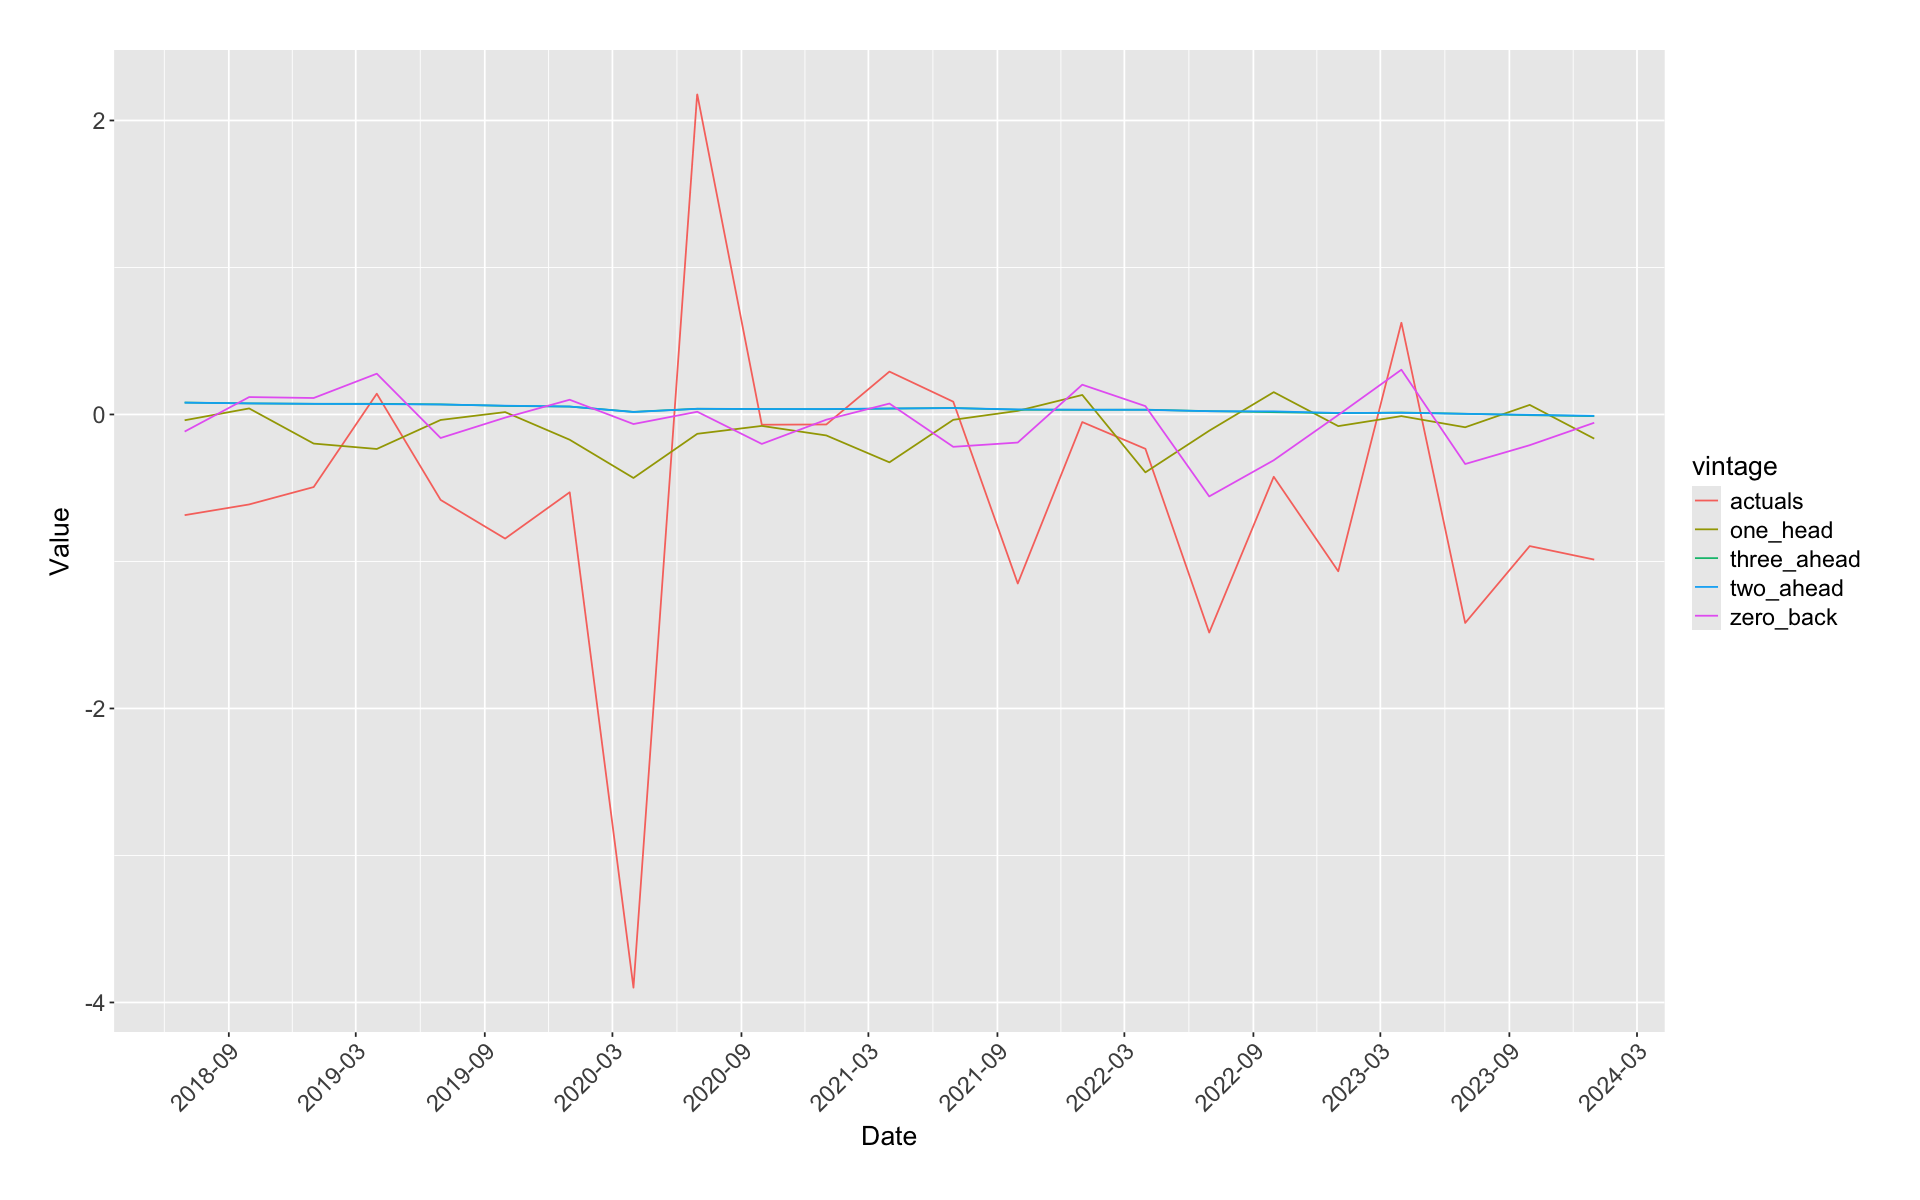

In [11]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>%
    select(!!target_variable) %>%
    pull()

performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

# Extract dates from pred_dict
dates <- pred_dict$date

p <- tibble(
    date = dates,
    actuals = actuals,
    zero_back = pred_dict[, "0"],
    one_head = pred_dict[, "1"],
    two_ahead = pred_dict[, "2"],
    three_ahead = pred_dict[, "3"]
) %>%
    gather(vintage, value, -date) %>%
    ggplot() + 
    aes(x = date, y = value, color = vintage) + 
    geom_line() +
    scale_x_date(date_breaks = "6 months", date_labels = "%Y-%m") +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        axis.text.x = element_text(angle = 45, hjust = 1),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        plot.margin = margin(30, 30, 30, 30)
    ) +
    labs(x = "Date", y = "Value")

options(repr.plot.width = 16, repr.plot.height = 10)

print(p)


In [14]:
# Save predictions to CSV
setwd(project_dir)
write.csv(pred_dict, file = file.path('results', 'midas_deseason.csv'), row.names = FALSE)

# Verify if the file was created successfully
if (file.exists(file.path('results', 'midas_deseason.csv'))) {
  print("CSV file successfully saved.")
} else {
  print("Error: CSV file was not saved. Please check the file path and permissions.")
}

[1] "CSV file successfully saved."
